**Movie recommender by: Sepehr Mousaviyan**

# Import required libaries

In [124]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
# ! pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import ast
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
# ! pip install surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

pd.options.display.max_columns=None

import warnings
warnings.simplefilter('ignore')

from datetime import datetime
! pip install tensorflow tensorflow_recommenders
import tensorflow as tf
import tensorflow_recommenders as tfrs

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from typing import Dict, Text

In [ ]:
# ! pwd
# ! ls drive/MyDrive/Movie_Recommender/archive

drive.mount('/content/drive')

def readCSV(name):
  return pd.read_csv('/content/drive/MyDrive/Movie_Recommender/archive/{}'.format(name))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
md = readCSV('movies_metadata.csv')
links= readCSV('links_small.csv')
credits = readCSV('credits.csv')
keywords = readCSV('keywords.csv')
ratings = readCSV('ratings_small.csv')

<ipython-input-4-1755196bdf84>:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('/content/drive/MyDrive/Movie_Recommender/archive/{}'.format(name))


# Pre-process

Check missing values

In [ ]:
print('### md ###')
print( md.isnull().sum() / len(md) )
print('\n### links ###')
print( links.isnull().sum() / len(links) )
print('\n### credits ###')
print( credits.isnull().sum() / len(credits) )
print('\n### keywords ###')
print( keywords.isnull().sum() / len(keywords) )
print('\n### ratings ###')
print( ratings.isnull().sum() / len(ratings) )

### md ###
adult                    0.000000
belongs_to_collection    0.901157
budget                   0.000000
genres                   0.000000
homepage                 0.828839
id                       0.000000
imdb_id                  0.000374
original_language        0.000242
original_title           0.000000
overview                 0.020983
popularity               0.000110
poster_path              0.008490
production_companies     0.000066
production_countries     0.000066
release_date             0.001914
revenue                  0.000132
runtime                  0.005785
spoken_languages         0.000132
status                   0.001914
tagline                  0.551049
title                    0.000132
video                    0.000132
vote_average             0.000132
vote_count               0.000132
dtype: float64

### links ###
movieId    0.000000
imdbId     0.000000
tmdbId     0.001425
dtype: float64

### credits ###
cast    0.0
crew    0.0
id      0.0
dtype: float64


In [ ]:
md = md[["id","title","genres","original_language","overview","release_date","vote_average", "vote_count"]]
credits = credits[["id","cast"]]

In [ ]:
md["id"] = md["id"].astype(str)
md["title"] = md["title"].astype(str)
md["genres"] = md["genres"].astype(str)
md["original_language"] = md["original_language"].astype(str)
md["overview"] = md["overview"].astype(str)
md["release_date"] = md["release_date"].astype(str)
md.dtypes

id                    object
title                 object
genres                object
original_language     object
overview              object
release_date          object
vote_average         float64
vote_count           float64
dtype: object

In [ ]:
def unpack_genre(x):
    eval_x = literal_eval(x)
    if len(eval_x) == 0:
        return None
    else:
        return [ i['name'] for i in eval_x]
md['genres'] = md.genres.apply(lambda x : unpack_genre(x) )

In [ ]:
def transform_date(x):
    x = x.split("-")[0]
    if x == 'nan':
        return None
    else:
        return x
md["release_date"] = md.release_date.apply(lambda x : transform_date(x) )

In [ ]:
keywords["id"] = keywords["id"].astype(str)
keywords["keywords"] = keywords["keywords"].astype(str)
keywords.dtypes

id          object
keywords    object
dtype: object

In [ ]:
def unpack_keywords(x):
    eval_x = literal_eval(x)
    if len(eval_x) == 0:
        return None
    else:
        return [ i['name'] for i in eval_x]
keywords['keywords'] = keywords.keywords.apply(lambda x : unpack_keywords(x) )

In [ ]:
ratings["userId"] = ratings["userId"].astype(str)
ratings["movieId"] = ratings["movieId"].astype(str)
ratings.dtypes

userId        object
movieId       object
rating       float64
timestamp      int64
dtype: object

In [ ]:
credits["id"] = credits["id"].astype(str)
credits["cast"] = credits["cast"].astype(str)
credits.dtypes

id      object
cast    object
dtype: object

In [ ]:
! pip install pandarallel
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
def unpack_cast(x):
    eval_x = literal_eval(x)
    if len(eval_x) == 0:
        return None
    else:
        return [ i['name'] for i in eval_x]
credits["cast"] = credits.cast.parallel_apply(lambda x : unpack_cast(x) )

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
movies = pd.merge(md, keywords, on='id', how='inner')
movies = pd.merge(movies, credits, on='id', how='inner').rename(columns={"id":"movieId"})
movies = movies.dropna(subset=["release_date"])
movies["release_date"] = movies["release_date"].astype('int32')
movies.head(3)

,movieId,title,genres,original_language,overview,release_date,vote_average,vote_count,keywords,cast
0,862,Toy Story,"[Animation, Comedy, Family]",en,"Led by Woody, Andy's toys live happily in his ...",1995,7.7,5415.0,"[jealousy, toy, boy, friendship, friends, riva...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,8844,Jumanji,"[Adventure, Fantasy, Family]",en,When siblings Judy and Peter discover an encha...,1995,6.9,2413.0,"[board game, disappearance, based on children'...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,15602,Grumpier Old Men,"[Romance, Comedy]",en,A family wedding reignites the ancient feud be...,1995,6.5,92.0,"[fishing, best friend, duringcreditsstinger, o...","[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."


In [ ]:
movie_ratings = pd.merge( ratings, movies,  on='movieId', how='left')
movie_ratings.head(3)

,userId,movieId,rating,timestamp,title,genres,original_language,overview,release_date,vote_average,vote_count,keywords,cast
0,1,31,2.5,1260759144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1029,3.0,1260759179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1061,3.0,1260759182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Content based

This approach gives the user movies similar to movie the user have watched.

In [ ]:
links= links[links['tmdbId'].notnull()]['tmdbId'].astype('int')

In [ ]:
links.head(5)

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

In [ ]:
md = md.drop([19730, 29503, 35587])

In [ ]:
md['id'] = md['id'].astype('int')

In [ ]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 24)

In [ ]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

<ipython-input-14-8b022d10038a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['tagline'] = smd['tagline'].fillna('')
<ipython-input-14-8b022d10038a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['description'] = smd['overview'] + smd['tagline']
<ipython-input-14-8b022d10038a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [ ]:
tfidf_matrix.shape

(9099, 268124)

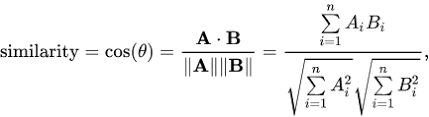

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
get_recommendations('Outbreak').head(20)

7866                       Contagion
3693                   Osmosis Jones
3996                   Resident Evil
6962                   The Happening
6886                        Doomsday
7048                      Quarantine
31                    Twelve Monkeys
7401                       Pontypool
8871                          Maggie
7400                        Carriers
4664                   28 Days Later
149                          Hackers
1236                         Con Air
2989                        Badlands
3384                    The Forsaken
3592    American Ninja 3: Blood Hunt
12                             Balto
7311                          Thirst
7596        Resident Evil: Afterlife
4551         Cowboy Bebop: The Movie
Name: title, dtype: object

Based on meta data

In [ ]:
credits.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [ ]:
keywords.head(5)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')
md.shape

(45463, 24)

In [ ]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [ ]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 27)

In [ ]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

<ipython-input-35-0380b14b24f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['cast'] = smd['cast'].apply(literal_eval)
<ipython-input-35-0380b14b24f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['crew'] = smd['crew'].apply(literal_eval)
<ipython-input-35-0380b14b24f8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
smd['director'] = smd['crew'].apply(get_director)
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:4] if len(x) >=4 else x)
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

<ipython-input-37-48201c187769>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['director'] = smd['crew'].apply(get_director)
<ipython-input-37-48201c187769>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
<ipython-input-37-48201c187769>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x,x])

<ipython-input-38-101b592082c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
<ipython-input-38-101b592082c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
<ipython-input-38-101b592082c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [ ]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

<ipython-input-39-b4f6ebaa1571>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)


In [ ]:
s = s.value_counts()
s[:10]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
violence                264
love                    222
musical                 219
sex                     219
suspense                212
Name: keyword, dtype: int64

In [ ]:
s = s[s > 1]

In [ ]:
stemmer = SnowballStemmer('english')
stemmer.stem('sportingly')

'sport'

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

<ipython-input-48-00d9efff34c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['keywords'] = smd['keywords'].apply(filter_keywords)
<ipython-input-48-00d9efff34c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
<ipython-input-48-00d9efff34c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [59]:
smd['soup'] = smd['keywords']
smd['soup'] = smd['soup'] + smd['cast']
smd['soup'] = smd['soup'] + smd['director']
# smd['soup'] = smd['soup'] + smd['genre']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

<ipython-input-59-a1b3590e4893>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['soup'] = smd['keywords']
<ipython-input-59-a1b3590e4893>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['soup'] = smd['soup'] + smd['cast']
<ipython-input-59-a1b3590e4893>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [60]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [61]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [62]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [73]:
get_recommendations('Memento').head(5)

2085        Following
4145         Insomnia
6623     The Prestige
7648        Inception
6218    Batman Begins
Name: title, dtype: object

# Collabrative filtering

In this approach we will find two users that are watched same movie and suggest their another watchlist to the another user.

In [80]:
reader = Reader()
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [83]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'],cv=5)

{'test_rmse': array([0.89665352, 0.90484874, 0.89035631, 0.89199709, 0.90158227]),
 'test_mae': array([0.68791126, 0.69611502, 0.6885603 , 0.68804705, 0.69375648]),
 'fit_time': (1.7536168098449707,
  2.022871255874634,
  1.3456358909606934,
  1.3679368495941162,
  1.3876891136169434),
 'test_time': (0.45347023010253906,
  0.2014305591583252,
  0.12919950485229492,
  0.15975427627563477,
  0.14824986457824707)}

In [84]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [87]:
user_rating=pd.merge(ratings,md,left_on='movieId',right_on='id',how='inner')
user_ratings_final=user_rating[['userId', 'movieId', 'rating','original_title']]
user_ratings=user_ratings_final.sort_values(by='userId')
user_ratings.head()

,userId,movieId,rating,original_title
0,1,1371,2.5,Rocky III
93,1,2105,4.0,American Pie
140,1,2193,2.0,My Tutor
47,1,1405,1.0,Greed
182,1,2294,2.0,Jay and Silent Bob Strike Back


In [89]:
user_ratings[user_ratings['userId'] == 3]

,userId,movieId,rating,original_title
7020,3,866,3.0,Finding Neverland
5955,3,593,3.0,Солярис
7047,3,1271,3.0,300
5342,3,588,3.0,Silent Hill
7087,3,1378,4.0,Shortbus
7115,3,1580,3.5,Rope
3240,3,377,2.5,A Nightmare on Elm Street
2215,3,296,4.5,Terminator 3: Rise of the Machines
7513,3,2028,4.0,Say Anything...
6396,3,267,3.0,Carne trémula


In [91]:
movie1=md['original_title']=='The Conjuring'
md[movie1][['original_title','id']]

,original_title,id
21475,The Conjuring,138843


In [92]:
svd.predict(3, 138843, 3)

Prediction(uid=3, iid=138843, r_ui=3, est=3.3397851571948416, details={'was_impossible': False})

# Combine contetnt based and collabrative filtering

In this approach we use a combination of content based and collabraative filtering.

In [93]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [94]:
id_map = pd.read_csv('/content/drive/MyDrive/Movie_Recommender/archive//links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [95]:
indices_map = id_map.set_index('id')

In [99]:
def recommend_my_movie(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [100]:
recommend_my_movie(3, "Inception")

,title,vote_count,vote_average,id,est
3381,Memento,4168.0,8.1,77,4.053706
6623,The Prestige,4510.0,8.0,1124,3.881149
8613,Interstellar,11187.0,8.1,157336,3.816187
9031,The Walk,1151.0,6.9,285783,3.626926
6981,The Dark Knight,12269.0,8.3,155,3.555424
9088,The Night Before,548.0,6.1,296100,3.540242
6218,Batman Begins,7511.0,7.5,272,3.517683
5131,Latter Days,57.0,6.8,15708,3.469950
8267,Lincoln,1456.0,6.7,72976,3.450734
6193,Mysterious Skin,266.0,7.4,11171,3.436867


In [101]:
recommend_my_movie(7, "Inception")

,title,vote_count,vote_average,id,est
3381,Memento,4168.0,8.1,77,4.026143
6623,The Prestige,4510.0,8.0,1124,3.938831
8613,Interstellar,11187.0,8.1,157336,3.872429
6981,The Dark Knight,12269.0,8.3,155,3.861982
6218,Batman Begins,7511.0,7.5,272,3.718252
8031,The Dark Knight Rises,9263.0,7.6,49026,3.597137
6734,The Lookout,209.0,6.6,8270,3.428595
9031,The Walk,1151.0,6.9,285783,3.414679
6193,Mysterious Skin,266.0,7.4,11171,3.374245
8267,Lincoln,1456.0,6.7,72976,3.359400


# Simple method

In [ ]:
df_md = readCSV('movies_metadata.csv')

df_md.head(5)

<ipython-input-52-5cc4ddf5c41e>:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('/content/drive/MyDrive/Movie_Recommender/archive/{}'.format(name))


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
vote_counts = df_md[df_md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = df_md[df_md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()

m = vote_counts.quantile(0.95)


In [ ]:
df_md['year'] = pd.to_datetime(df_md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
qualified = df_md[(df_md['vote_count'] >= m) & (df_md['vote_count'].notnull()) & (df_md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')

qualified.shape

(2274, 6)

In [ ]:
# This is what imdb is using
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

qualified = qualified.sort_values('wr', ascending=False).head(250)

Show top movies

In [ ]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",7.897107
2843,Fight Club,1999,9678,8,63.869599,"[{'id': 18, 'name': 'Drama'}]",7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",7.851924


In [ ]:
s = df_md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = df_md.drop('genres', axis=1).join(s)

In [ ]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')

    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)

    return qualified

Show top comedy movies

In [ ]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr


# Demographic

Demographic Filtering -
Before getting started with this -

we need a metric to score or rate movie
Calculate the score for every movie
Sort the scores and recommend the best rated movie to the users.
We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, I'll be using IMDB's weighted rating (wr) which is given as :-

where,

v is the number of votes for the movie;
m is the minimum votes required to be listed in the chart;
R is the average rating of the movie; And
C is the mean vote across the whole report
We already have v(vote_count) and R (vote_average) and C can be calculated as

In [ ]:
df_tmdb_movies=pd.read_csv('/content/drive/MyDrive/Movie_Recommender/tmdb/tmdb_5000_movies.csv')
df_tmdb_credits=pd.read_csv('/content/drive/MyDrive/Movie_Recommender/tmdb/tmdb_5000_credits.csv')

In [ ]:
C= df_tmdb_movies['vote_average'].mean()
m= df_tmdb_movies['vote_count'].quantile(0.9)

In [ ]:
q_movies = df_tmdb_movies.copy().loc[df_tmdb_movies['vote_count'] >= m]
q_movies.shape

(481, 20)

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [ ]:
q_movies = q_movies.sort_values('score', ascending=False)

q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


# Cluster-Based method

In [ ]:
df_ratings = readCSV('ratings_small.csv')
df_ratings.head(5)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
df_md.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

<Axes: >

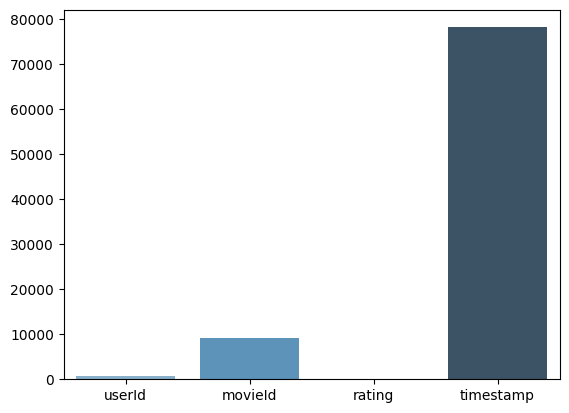

In [ ]:
sns.barplot(x = df_ratings.columns, y = df_ratings.nunique (axis=0), palette="Blues_d")

<Axes: ylabel='Frequency'>

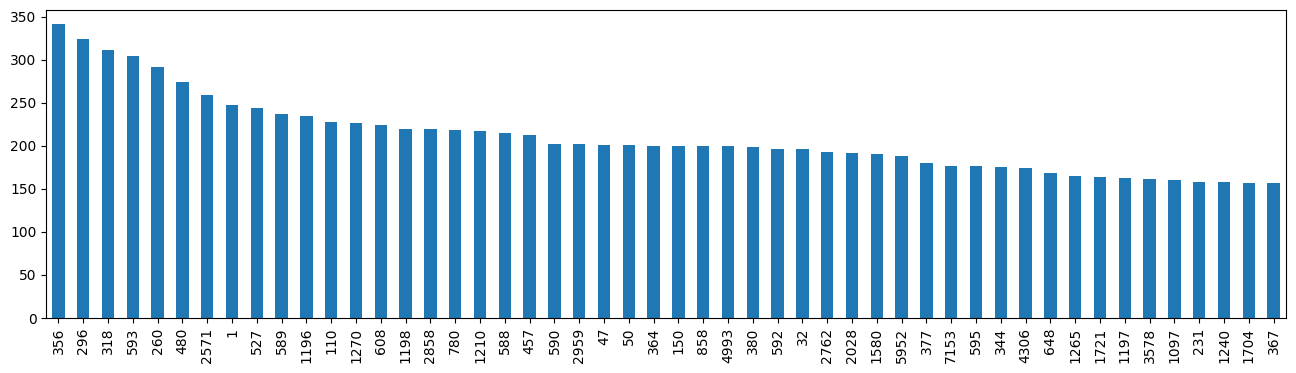

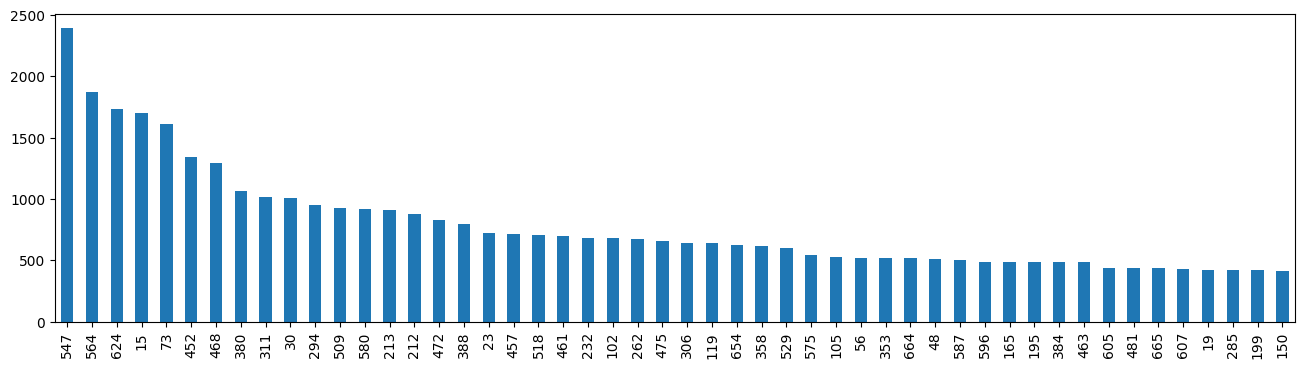

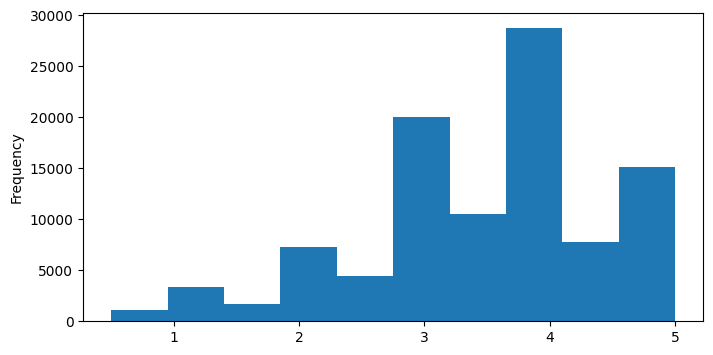

In [ ]:
plt.figure(1, figsize = (16,4))
df_ratings['movieId'].value_counts()[:50].plot(kind = 'bar') #take top 50 movies
plt.figure(2, figsize = (16,4))
df_ratings['userId'].value_counts()[:50].plot(kind = 'bar') #take top 50 users
plt.figure(3, figsize = (8,4))
df_ratings['rating'].plot(kind = 'hist')

##SVD & KNN

In [ ]:
!pip install scikit-surprise
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import Reader

# k Nearest Neighbour
similarity = {
    "name": "cosine",
    "user_based": True,
}
algo_KNN = KNNWithMeans(sim_options = similarity)


# SVD
algo_SVD = SVD()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3096331 sha256=6817bc5c2dedabf3e397c7636067c2bf5c2ae685e18f956c99bb61233d24274a
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
movie_rating_set = pd.crosstab(index = df_ratings.userId, columns = df_ratings.movieId, values = df_ratings.rating, aggfunc = np.mean)

In [ ]:
# load df into Surprise Reader object
reader = Reader(rating_scale = (0,5))
rating_df = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

# load df into Surprise Reader object
reader = Reader(rating_scale = (0,5))
rating_df = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
## Method 1. cross validation ##
from surprise.model_selection import cross_validate

cross_validate_KNN = cross_validate(algo_KNN, rating_df, measures=['RMSE', 'MAE'], cv=5, verbose=True)

cross_validate_SVD = cross_validate(algo_SVD, rating_df, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9217  0.9204  0.9221  0.9185  0.9387  0.9243  0.0073  
MAE (testset)     0.7089  0.7066  0.7052  0.7040  0.7184  0.7086  0.0051  
Fit time          0.14    0.21    0.17    0.16    0.15    0.16    0.03    
Test time         2.12    2.15    1.19    1.14    1.46    1.61    0.44    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9081  0.8943  0.8920  0.8924  0.8

In [ ]:
## Method 2. build training and testing set ##
from surprise.model_selection import train_test_split
from surprise import accuracy

# define train test function
#Split data in 80% for training & 20% for testing
def train_test_algo(algo, label):
    training_set, testing_set = train_test_split(rating_df, test_size = 0.2)
    algo.fit(training_set)
    test_output = algo.test(testing_set)
    test_df = pd.DataFrame(test_output)

    print("RMSE -",label, accuracy.rmse(test_output, verbose = False))
    print("MAE -", label, accuracy.mae(test_output, verbose=False))
    print("MSE -", label, accuracy.mse(test_output, verbose=False))

    return test_df

In [ ]:
# get test result
train_test_KNN = train_test_algo(algo_KNN, "algo_KNN")
print(train_test_KNN.head())

train_test_SVD = train_test_algo(algo_SVD, "algo_SVD")
print(train_test_SVD.head())

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE - algo_KNN 0.9217616197868049
MAE - algo_KNN 0.7045947412216218
MSE - algo_KNN 0.8496444837119943
   uid     iid  r_ui       est                                    details
0  615  100163   2.0  3.402756   {'actual_k': 1, 'was_impossible': False}
1  268    2968   3.5  3.717829  {'actual_k': 33, 'was_impossible': False}
2  639     454   3.0  3.315801  {'actual_k': 40, 'was_impossible': False}
3   23     805   3.5  3.805541  {'actual_k': 39, 'was_impossible': False}
4  235     222   4.5  4.627072  {'actual_k': 19, 'was_impossible': False}
RMSE - algo_SVD 0.8923855896963753
MAE - algo_SVD 0.6888374808176226
MSE - algo_SVD 0.7963520406977475
   uid    iid  r_ui       est                    details
0   19   1374   3.0  3.696705  {'was_impossible': False}
1  396    110   3.0  4.017689  {'was_impossible': False}
2  586   3006   4.5  3.428115  {'was_impossible': False}
3  632   2501   5.0  4.532134  {'was_impossibl

In [ ]:
# load movie data and links data
# We need to see the actual recommendation with movie names.
# Firstly, let's load the movie metadata table, so that we gte recommended movie name.

movie_df = pd.read_csv("/content/drive/MyDrive/Movie_Recommender/archive/movies_metadata.csv")
links_df = pd.read_csv("/content/drive/MyDrive/Movie_Recommender/archive/links.csv")
movie_df['imdb_id'] = movie_df['imdb_id'].apply(lambda x: str(x)[2:].lstrip("0"))
links_df['imdbId'] = links_df['imdbId'].astype(str)

<ipython-input-50-6dca8d4f3a34>:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_df = pd.read_csv("/content/drive/MyDrive/Movie_Recommender/archive/movies_metadata.csv")


In [ ]:
# Prediction
def prediction(algo, users_K):
    pred_list = []
    for userId in range(1,users_K):
        for movieId in range(1,9067):
            rating = algo.predict(userId, movieId).est
            pred_list.append([userId, movieId, rating])
    pred_df = pd.DataFrame(pred_list, columns = ['userId', 'movieId', 'rating'])
    return pred_df

In [ ]:
# merge the dataset together using pd.merge();
# group the ratings by userId and sort it by rating value in a descending order;
# get the top values using head();
# return both the sorted recommendations and the top recommended movies

def top_recommendations(pred_df, top_N):
    link_movie = pd.merge(pred_df, links_df, how='inner', left_on='movieId', right_on='movieId')
    recommended_movie = pd.merge(link_movie, movie_df, how='left', left_on='imdbId', right_on='imdb_id')[['userId', 'movieId', 'rating', 'movieId','imdb_id','title']]
    sorted_df = recommended_movie.groupby(('userId'), as_index = False).apply(lambda x: x.sort_values(['rating'], ascending = False)).reset_index(drop=True)
    top_recommended_movies = sorted_df.groupby('userId').head(top_N)
    return sorted_df, top_recommended_movies

In [ ]:
# KNN predictions
pred_KNN = prediction(algo_KNN, 10)
recommended_movies_KNN, top_recommended_movies_KNN = top_recommendations(pred_KNN, 3)



## SVD predictions
pred_SVD = prediction(algo_SVD, 10)
recommended_movies_SVD, top_recommended_movies_SVD = top_recommendations(pred_SVD, 3)

In [ ]:
top_recommended_movies_KNN

,userId,movieId,rating,movieId,imdb_id,title
0,1,4731,4.781298,4731,251141,Innocence
1,1,5071,4.781298,5071,220627,Maelström
2,1,9010,4.526126,9010,364517,Love Me If You Dare
8341,2,5244,5.000000,5244,81506,Shogun Assassin
8342,2,5301,5.000000,5301,72705,Bite the Bullet
8343,2,1563,5.000000,1563,119019,Dream with the Fishes
16682,3,8797,5.000000,8797,64921,Salesman
16683,3,3021,5.000000,3021,82427,The Funhouse
16684,3,7087,5.000000,7087,87892,A Passage to India
25023,4,8420,5.000000,8420,39725,Possessed


In [ ]:
top_recommended_movies_SVD

,userId,movieId,rating,movieId,imdb_id,title
0,1,905,3.790023,905,25316,It Happened One Night
1,1,4226,3.730056,4226,209144,Memento
2,1,1221,3.674456,1221,71562,The Godfather: Part II
8341,2,969,4.546984,969,43265,The African Queen
8342,2,50,4.411809,50,114814,The Usual Suspects
8343,2,4235,4.410748,4235,245712,Amores perros
16682,3,926,4.476132,926,42192,All About Eve
16683,3,1221,4.447597,1221,71562,The Godfather: Part II
16684,3,2064,4.397293,2064,98213,Roger & Me
25023,4,1259,5.000000,1259,92005,Stand by Me


# Graph based

Graph based method

In [ ]:
rating = readCSV('ratings.csv')
meta = readCSV('movies_metadata.csv')

<ipython-input-52-5cc4ddf5c41e>:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('/content/drive/MyDrive/Movie_Recommender/archive/{}'.format(name))


In [ ]:
def is_int(x):
    if str(x).__contains__('-'):
        return False
    return type(eval(x))==int
meta = meta[meta['id'].apply(is_int)]

meta.loc[:,'id'] = meta.loc[:,'id'].astype('int64')

<ipython-input-75-c39c3ca9a2a6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta.loc[:,'id'] = meta.loc[:,'id'].astype('int64')
<ipython-input-75-c39c3ca9a2a6>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  meta.loc[:,'id'] = meta.loc[:,'id'].astype('int64')


In [ ]:
merged = rating.merge(meta,left_on='movieId',right_on='id')
rating_filtered = merged[['userId','movieId','rating','timestamp']]
rating_filtered

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,11,110,3.5,1231676989
2,22,110,5.0,1111937009
3,24,110,5.0,979870012
4,29,110,3.0,1044020005
...,...,...,...,...
11437632,270123,140222,3.0,1440920139
11437633,270123,151509,3.0,1453527817
11437634,270123,159109,1.5,1465361347
11437635,270694,165159,4.0,1476635117


In [ ]:
rating_filtered_50votes = rating_filtered.groupby('movieId').agg('count').reset_index().drop(columns=['rating','timestamp'])
rating_filtered_50votes = rating_filtered_50votes[rating_filtered_50votes['userId']>=50]
rating_filtered_50votes = rating_filtered_50votes.drop(columns=['userId'])

In [ ]:
rating_filtered_1 = rating_filtered.merge(rating_filtered_50votes)
rating_filtered_1

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,11,110,3.5,1231676989
2,22,110,5.0,1111937009
3,24,110,5.0,979870012
4,29,110,3.0,1044020005
...,...,...,...,...
11388878,250744,5511,3.0,1031771929
11388879,255672,5511,4.0,1206381024
11388880,255672,5511,4.0,1206381024
11388881,255904,5511,3.0,1184346248


In [ ]:
def label_rating(x):
    if x<3.0: #0-2.5
        return 0
    elif x <= 3.5: # 3.0, 3.5
        return 1
    else: # 4.0 4.5, 5.0
        return 2

# rating_filtered_1['label'] = rating_filtered_1['rating'].apply(label_rating)
# rating_filtered_1

In [ ]:
rating_label = rating_filtered_1.groupby('movieId')['rating'].agg('mean').reset_index()
rating_label['label'] = rating_label['rating'].apply(label_rating)
rating_label

,movieId,rating,label
0,2,3.236953,1
1,3,3.175550,1
2,5,3.079565,1
3,6,3.841764,2
4,11,3.660591,2
...,...,...,...
3675,166643,3.977663,2
3676,167738,2.903226,0
3677,168712,2.291429,0
3678,169864,3.247887,1


<Axes: >

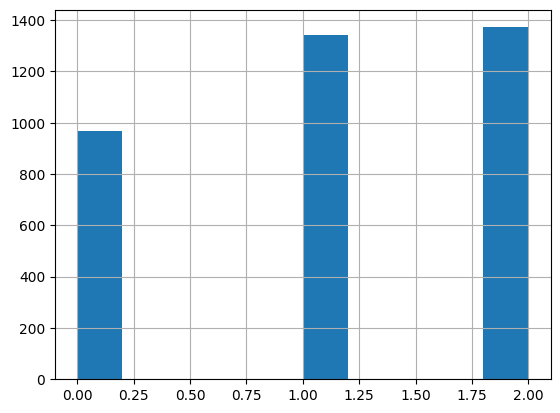

In [ ]:
rating_label['label'].hist()


<Axes: >

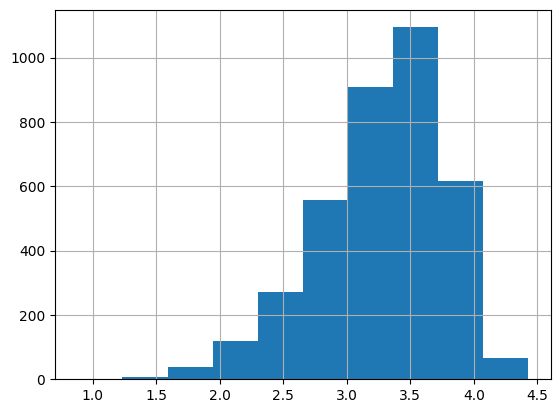

In [ ]:
rating_label['rating'].hist()


Construct Edges

In [ ]:
rating_filtered_1[['movieId','timestamp']].groupby('movieId').agg(['min','mean','std']).reset_index().head(10)

movieId  timestamp                            
                 min          mean           std
0       2  822873600  1.088621e+09  2.170602e+08
1       3  822959685  9.661124e+08  1.581572e+08
2       5  822959686  9.896788e+08  1.968917e+08
3       6  823185240  1.034524e+09  2.045924e+08
4      11  822873600  9.726948e+08  1.595994e+08
5      12  822873600  1.014597e+09  1.963985e+08
6      13  823264414  1.104046e+09  2.276767e+08
7      14  822959699  9.346318e+08  1.508796e+08
8      15  822960056  9.880865e+08  1.732315e+08
9      16  822959684  1.086367e+09  1.996835e+08

In [ ]:
rating_filtered_1[['movieId','timestamp']].groupby('movieId').agg(['min','mean','std']).reset_index().describe()

movieId     timestamp                            
                               min          mean           std
count    3680.000000  3.680000e+03  3.680000e+03  3.680000e+03
mean    19733.173641  1.021996e+09  1.165365e+09  1.257826e+08
std     30260.088459  1.658051e+08  1.459585e+08  3.981345e+07
min         2.000000  7.896520e+08  8.769963e+08  3.126857e+06
25%      1634.500000  8.756249e+08  1.047060e+09  1.015797e+08
50%      4572.000000  9.943041e+08  1.144108e+09  1.260821e+08
75%     27676.250000  1.143925e+09  1.284108e+09  1.543836e+08
max    170399.000000  1.490347e+09  1.498694e+09  2.389149e+08

In [ ]:
rating_filtered_1[['movieId','userId']].groupby('userId').agg('count').rename(columns={'movieId':'user_rating_cnt'}).describe()

,user_rating_cnt
count,265882.000000
mean,42.834351
std,76.488289
min,1.000000
25%,7.000000
50%,16.000000
75%,45.000000
max,2477.000000


In [ ]:
rating_filtered_1

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,11,110,3.5,1231676989
2,22,110,5.0,1111937009
3,24,110,5.0,979870012
4,29,110,3.0,1044020005
...,...,...,...,...
11388878,250744,5511,3.0,1031771929
11388879,255672,5511,4.0,1206381024
11388880,255672,5511,4.0,1206381024
11388881,255904,5511,3.0,1184346248


In [ ]:
ratings_usergeq45 = rating_filtered_1.groupby('userId').filter(lambda x: len(x) >= 45 and len(x)<=100)
ratings_usergroup = ratings_usergeq45.groupby('userId')['movieId'].apply(lambda x: ','.join(x.astype(str))).reset_index(name='merged_movie_id')
ratings_usergroup

,userId,merged_movie_id
0,8,"1968,2762,4896,318,4993,170,553,585,647,653,78..."
1,11,"110,2959,4226,54503,58559,260,480,500,527,3578..."
2,15,"2959,58559,260,1732,2692,3578,296,541,750,293,..."
3,16,"2959,4226,260,480,1732,296,541,318,68954,88744..."
4,20,"858,2959,58559,260,780,480,1422,1732,2355,3114..."
...,...,...
38722,270872,"110,858,4226,260,780,480,296,750,318,5618,3918..."
38723,270877,"339,480,11,585,594,153,165,344,349,380,588,592..."
38724,270885,"110,858,2959,58559,1732,2694,296,293,4993,3918..."
38725,270893,"110,1968,4226,780,527,1645,1732,2355,157,750,3..."


In [ ]:
from itertools import combinations

def get_combinations(row):
    numbers = row['merged_movie_id'].split(',')
    return pd.DataFrame(list(combinations(numbers, 2)), columns=['t1', 't2'])

dfs = []
for index, row in ratings_usergroup.iterrows():
    dfs.append(get_combinations(row))

In [ ]:
edge_df = pd.concat(dfs, ignore_index=True)
edge_df.drop_duplicates(inplace=True)
edge_df

,t1,t2
0,1968,2762
1,1968,4896
2,1968,318
3,1968,4993
4,1968,170
...,...,...
89549667,2165,4043
89549668,2165,4475
89549672,2360,4475
89549677,662,4475


In [ ]:
edge_df_1 = pd.concat(dfs, ignore_index=True)

grouped = edge_df_1.groupby(['t1', 't2']).size().reset_index(name='counts')

filtered = grouped.query('counts > 5')

edge_df_freq5 = filtered[['t1', 't2']].drop_duplicates()

In [ ]:
edge_df_freq5

In [ ]:
edge_df_freq5.loc[:,'t1'] = edge_df_freq5.loc[:,'t1'].astype('int64')
edge_df_freq5.loc[:,'t2'] = edge_df_freq5.loc[:,'t2'].astype('int64')

In [ ]:
len(set(edge_df_freq5['t1'].unique()).union(set(edge_df_freq5['t2'].unique())))

In [ ]:
rating_label = rating_label[['movieId','label']]

merged_df1 = pd.merge(edge_df_freq5, rating_label, left_on='t1', right_on='movieId', how='left')
merged_df2 = pd.merge(edge_df_freq5, rating_label, left_on='t2', right_on='movieId', how='left')

result_df = pd.concat([merged_df1[['t1', 'label']].rename(columns={'label': 't1_label'}),
                       merged_df2[['t2', 'label']].rename(columns={'label': 't2_label'})],
                      ignore_index=True,axis=1)
result_df.columns=['t1','t1_label','t2','t2_label']
result_df

In [ ]:
(result_df['t1_label'] == result_df['t2_label']).sum() / len(result_df)

In [ ]:
result_df.to_csv('MovieLens_avgrating.csv')

In [ ]:
result_df

# Deep Learning approach

In this section I used TensorFlow Recommenders (TFRS) for building a recommender system.

In [110]:
ratings

,userId,movieId,rating,date
0,1,31,2.5,2009-12-14 02:52:24
1,1,1029,3.0,2009-12-14 02:52:59
2,1,1061,3.0,2009-12-14 02:53:02
3,1,1129,2.0,2009-12-14 02:53:05
4,1,1172,4.0,2009-12-14 02:53:25
...,...,...,...,...
99999,671,6268,2.5,2003-10-08 02:16:10
100000,671,6269,4.0,2003-10-03 02:46:41
100001,671,6365,4.0,2003-12-09 03:26:03
100002,671,6385,2.5,2003-12-09 14:21:03


In [112]:
# ratings['date'] = ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
# ratings.drop('timestamp', axis=1, inplace=True)

ratings = ratings.merge(md[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings = ratings[~ratings['id'].isna()]
ratings.drop('id', axis=1, inplace=True)
ratings.reset_index(drop=True, inplace=True)

ratings.head(5)

,userId,movieId,rating,date,original_title,genres,overview
0,1,1371,2.5,2009-12-14 02:52:15,Rocky III,"[{'id': 18, 'name': 'Drama'}]","Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-14 02:53:23,Greed,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-14 02:52:19,American Pie,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-14 02:53:18,My Tutor,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-14 02:51:48,Jay and Silent Bob Strike Back,"[{'id': 35, 'name': 'Comedy'}]",When Jay and Silent Bob learn that their comic...


In [113]:
movies_df = md[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head(5)

,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [120]:
ratings['userId'] = ratings['userId'].astype(str)

ratings = tf.data.Dataset.from_tensor_slices(dict(ratings[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])


In [121]:
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(35_000)
test = ratings.skip(35_000).take(8_188)

Total Data: 45042


In [122]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

Unique Movies: 43370
Unique users: 671


In [126]:
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # Take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # Pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["original_title"])

    return (
        user_embeddings,
        movie_embeddings,
        # Apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # Compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)


In [127]:
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(1_000).cache()
cached_test = test.batch(1_000).cache()

model.fit(cached_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 262s 7s/step - root_mean_squared_error: 1.4371 - factorized_top_k/top_1_categorical_accuracy: 2.5714e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0067 - factorized_top_k/top_10_categorical_accuracy: 0.0172 - factorized_top_k/top_50_categorical_accuracy: 0.0911 - factorized_top_k/top_100_categorical_accuracy: 0.1575 - loss: 6813.1219 - regularization_loss: 0.0000e+00 - total_loss: 6813.1219
Epoch 2/5
35/35 [==============================] - 221s 6s/step - root_mean_squared_error: 1.0525 - factorized_top_k/top_1_categorical_accuracy: 9.4286e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0178 - factorized_top_k/top_10_categorical_accuracy: 0.0391 - factorized_top_k/top_50_categorical_accuracy: 0.1793 - factorized_top_k/top_100_categorical_accuracy: 0.2950 - loss: 6452.8295 - regularization_loss: 0.0000e+00 - total_loss: 6452.8295
Epoch 3/5
35/35 [==============================] - 207s 6s/step - root_mean_squared_error: 0.987

In [128]:
model.save_weights('tfrs.h5')

In [129]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

9/9 [==============================] - 52s 6s/step - root_mean_squared_error: 1.2093 - factorized_top_k/top_1_categorical_accuracy: 4.8852e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0021 - factorized_top_k/top_10_categorical_accuracy: 0.0057 - factorized_top_k/top_50_categorical_accuracy: 0.0259 - factorized_top_k/top_100_categorical_accuracy: 0.0508 - loss: 5722.5223 - regularization_loss: 0.0000e+00 - total_loss: 5722.5223

Retrieval top-100 accuracy: 0.051
Ranking RMSE: 1.209


In [130]:
def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))

    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))

In [131]:
predict_movie(52, 10)

Top 10 recommendations for user 52:

1. The Patriot
2. The Patriot
3. Once in a Lifetime: The Extraordinary Story of the New York Cosmos
4. The Heart of the World
5. Hababam Sınıfı Uyanıyor
6. Le Bossu
7. Barda
8. The Number 23
9. The Garden of Eden
10. The Mummy: Tomb of the Dragon Emperor


In [132]:
predict_rating(52,'Minions')

Predicted rating for Minions: 3.063401699066162


# Gradio

Change colab hardware to gpu

In [ ]:
# !pip install datasets
# !pip install transformers
# !pip install sentence_transformers
# !pip install faiss-gpu
# !pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=f4b12efd95c9e9300293f021b97afac002a156e84

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch

from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import gradio as gr

In [ ]:
! pwd
! ls ..
import os
from google.colab import drive
drive.mount('/content/drive')
movies = pd.read_csv('/content/drive/MyDrive/Movie_Recommender/archive/movies_metadata.csv', dtype={'title': str, 'overview': str})

/content
bin	 dev   lib32   mnt			 python-apt  srv    usr
boot	 etc   lib64   NGC-DL-CONTAINER-LICENSE  root	     sys    var
content  home  libx32  opt			 run	     tmp
datalab  lib   media   proc			 sbin	     tools
Mounted at /content/drive


<ipython-input-6-4542e9567d78>:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('/content/drive/MyDrive/Movie_Recommender/archive/movies_metadata.csv', dtype={'title': str, 'overview': str})


In [ ]:
movies.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [ ]:
movies['original_language'].unique()

array(['en', 'fr', 'zh', 'it', 'fa', 'nl', 'de', 'cn', 'ar', 'es', 'ru',
       'sv', 'ja', 'ko', 'sr', 'bn', 'he', 'pt', 'wo', 'ro', 'hu', 'cy',
       'vi', 'cs', 'da', 'no', 'nb', 'pl', 'el', 'sh', 'xx', 'mk', 'bo',
       'ca', 'fi', 'th', 'sk', 'bs', 'hi', 'tr', 'is', 'ps', 'ab', 'eo',
       'ka', 'mn', 'bm', 'zu', 'uk', 'af', 'la', 'et', 'ku', 'fy', 'lv',
       'ta', 'sl', 'tl', 'ur', 'rw', 'id', 'bg', 'mr', 'lt', 'kk', 'ms',
       'sq', nan, '104.0', 'qu', 'te', 'am', 'jv', 'tg', 'ml', 'hr', 'lo',
       'ay', 'kn', 'eu', 'ne', 'pa', 'ky', 'gl', '68.0', 'uz', 'sm', 'mt',
       '82.0', 'hy', 'iu', 'lb', 'si'], dtype=object)

<Axes: xlabel='original_language', ylabel='count'>

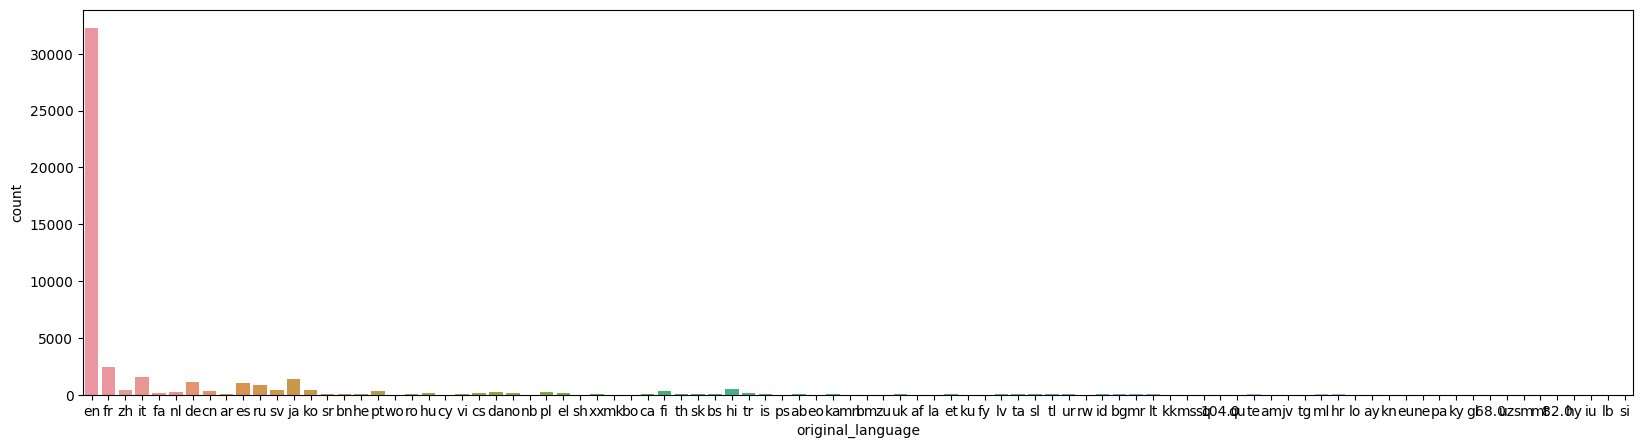

In [ ]:
plt.figure(figsize=(20,5))

sns.countplot(x=movies['original_language'])

In [ ]:
movies = movies[movies['original_language'] == 'en']

In [ ]:
print(movies['original_language'].unique())
movies.head(5)

['en']


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movies = movies[["original_title", "overview"]]

In [ ]:
movies.head(5)

,original_title,overview
0,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...


In [ ]:
print(movies['original_title'].isna().sum())
print(movies['overview'].isna().sum())

0
69


<Axes: xlabel='original_title', ylabel='Count'>

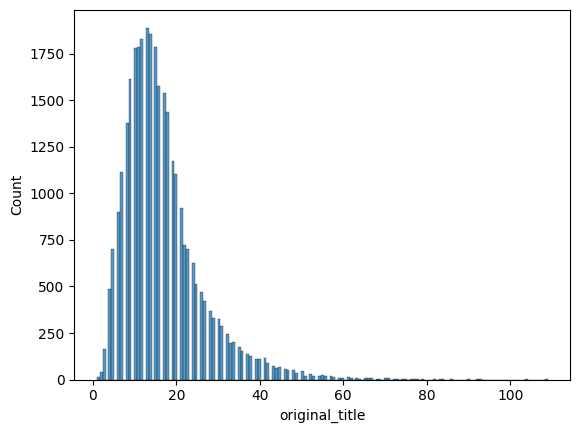

In [ ]:
#plt.figure(figsize=(20, 8))
titles_length = movies['original_title'].map(len)
sns.histplot(x=titles_length)

<Axes: xlabel='overview', ylabel='Count'>

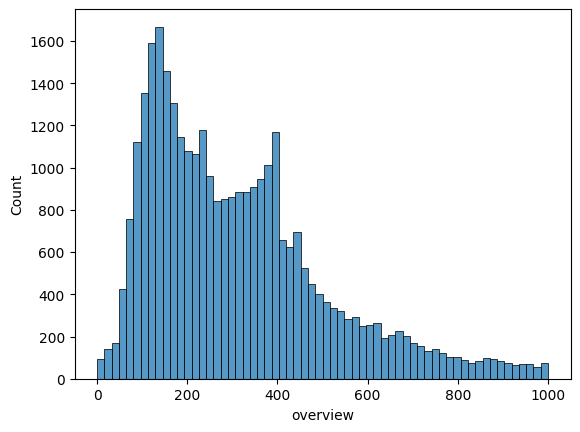

In [ ]:
movies['overview'] = movies['overview'].fillna('')
overview_length = movies['overview'].map(len)
sns.histplot(x=overview_length)

In [ ]:
movies_dataset = Dataset.from_pandas(movies, preserve_index=False)
movies_dataset

Dataset({
    features: ['original_title', 'overview'],
    num_rows: 32269
})

In [ ]:
def concatenate_text(row):
    return {
        "text": row['original_title']
        + '\n '
        + row['overview']
    }

movies_dataset = movies_dataset.map(concatenate_text)

Map:   0%|          | 0/32269 [00:00<?, ? examples/s]

In [ ]:
device = torch.device("cuda")

model_ckpt = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
model = SentenceTransformer(model_ckpt, device=device)

In [ ]:
def get_embeddings(text_list):
    embeddings = model.encode(text_list, convert_to_numpy=False, convert_to_tensor=True, show_progress_bar=False, device=device)
    return embeddings

embeddings = get_embeddings(movies_dataset['text'][0]).detach().cpu().numpy()
embeddings.shape

(768,)

In [ ]:
embeddings_dataset = movies_dataset.map(
    lambda x: {"embeddings": get_embeddings(x['text']).detach().cpu().numpy()}
)

Map:   0%|          | 0/32269 [00:00<?, ? examples/s]

In [ ]:
embeddings_dataset.add_faiss_index(column="embeddings")

  0%|          | 0/33 [00:00<?, ?it/s]

Dataset({
    features: ['original_title', 'overview', 'text', 'embeddings'],
    num_rows: 32269
})

In [ ]:
def search_movies(query_movie):
    query_embedding = get_embeddings(query_movie).detach().cpu().numpy()
    scores, top_movies = embeddings_dataset.get_nearest_examples(
        "embeddings", query_embedding, k=5
    )
    top_movies_df = pd.DataFrame.from_dict(top_movies)
    top_movies_df['scores'] = scores
    top_movies_df.sort_values('scores', ascending=False, inplace=True)
    return top_movies_df['original_title'].tolist()

In [ ]:
search_movies("seven")

NameError: ignored

## Gradio Demo

In [ ]:
demo = gr.Interface(fn=search_movies, inputs="text", outputs=["text"]*5)
demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
demo.close()

Closing server running on port: 7860


In [ ]:
import json
import requests
import pandas as pd
from tqdm import tqdm

In [ ]:
res = requests.get('https://api.themoviedb.org/3/discover/movie?primary_release_year=2022&api_key=817cc038e4426ea8ed4cd04aa8f8ce17&language=en-US&page=1')
res_json = json.loads(res.text)

movies_2022_df = pd.DataFrame.from_dict(res_json['results'])
movies_2022_df = movies_2022_df.iloc[0:0]

total_pages = res_json['total_pages']
for page in tqdm(range(1, 501)):
    res = requests.get(f'https://api.themoviedb.org/3/discover/movie?primary_release_year=2022&api_key=817cc038e4426ea8ed4cd04aa8f8ce17&language=en-US&page={page}')
    res_json = json.loads(res.text)
    df = pd.DataFrame.from_dict(res_json['results'])
    movies_2022_df = pd.concat([movies_2022_df, df], ignore_index=True)

100%|██████████| 500/500 [01:26<00:00,  5.79it/s]


In [ ]:
print("Expected movies: ", res_json['total_results'])
print("Total movies: ", movies_2022_df.shape[0])

Expected movies:  32631
Total movies:  10000


In [ ]:
movies_2022_df.to_csv('movies_2022.csv', index=False, line_terminator='\r')

<ipython-input-31-7ba058874e32>:1: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  movies_2022_df.to_csv('movies_2022.csv', index=False, line_terminator='\r')


In [ ]:
movies_df = pd.read_csv("movies_2022.csv")
movies_df.head(5)

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,False,/xDEVdWduhRdNS4PzA6wif6FjUQb.jpg,"[28, 14, 53]",1036561,en,Shadow Master,"After being slain by a group of criminals, a m...",1021.975,/67ZsRKbItt6B1yHlsJKgfPWOyuJ.jpg,2022-11-03,Shadow Master,False,6.9,58
1,False,/8rpDcsfLJypbO6vREc0547VKqEv.jpg,"[878, 12, 28]",76600,en,Avatar: The Way of Water,Set more than a decade after the events of the...,817.812,/t6HIqrRAclMCA60NsSmeqe9RmNV.jpg,2022-12-14,Avatar: The Way of Water,False,7.7,8980
2,False,/lQzSMhkAl90iXPirjnLbRHkxApC.jpg,[27],917007,en,Bed Rest,A pregnant woman on bed rest begins to wonder ...,778.991,/tiZF8b9T9fMcwvsEEkJ5ik1wCnV.jpg,2022-12-08,Bed Rest,False,6.8,70
3,False,/70DKGgzTwyC7fr3FGM6JSHGqmPm.jpg,"[28, 80, 9648, 53]",543504,cn,神探大战,When Hong Kong is rocked by multiple gruesome ...,689.104,/sNAeYA5EZ7ouoHnVxQ0vMbfgiEi.jpg,2022-07-08,Detective vs. Sleuths,False,6.4,28
4,False,/ulaj7IhW72EK0cGSnMpP0UixTTC.jpg,"[27, 53]",993867,en,Eradication,When an unknown disease wipes out most of the ...,541.453,/6XZYA9VtCcidCU8Hus0J0V9wFhY.jpg,2022-07-15,Eradication,False,6.6,41


In [ ]:
res = requests.get('https://api.themoviedb.org/3/discover/movie?primary_release_year=2022&api_key=817cc038e4426ea8ed4cd04aa8f8ce17&language=en-US&page=1')
res_json = json.loads(res.text)

# Interface with streamlit

In this section we make a user interface for our application with straemlit.

In [137]:
# !pip install streamlit
import  streamlit as st
st.title('Movie Recommender System')

2023-07-06 12:56:30.613 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [157]:
!streamlit run /usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.73.21.191:8501

  Stopping...
^C


In [169]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 3.179s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [170]:
!streamlit run drive/MyDrive/Movie_Recommender/streamlit/app.py &>/content/logs.txt &

In [177]:
!wget -q -O - ipv4.icanhazip.com

34.73.21.191


In [ ]:
!npx localtunnel --port 8501

npx: installed 22 in 2.079s
your url is: https://bumpy-boxes-stop.loca.lt


In [168]:
drive.mount('/content/drive')
!ls drive/MyDrive/Movie_Recommender/streamlit/

! cd content/drive/MyDrive/Movie_Recommender/streamlit
! ls drive/MyDrive/Movie_Recommender/streamlit

!streamlit run drive/MyDrive/Movie_Recommender/streamlit/app.py

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
app.py
/bin/bash: line 0: cd: content/drive/MyDrive/Movie_Recommender/streamlit: No such file or directory
app.py



  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.73.21.191:8501

  Stopping...
  Stopping...
